IMPORTING LIBRARIES

In this notebook I have used VGG-16 and ResNet-50 architectures to train the model.

In [10]:
import json, sys, random, os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import PIL
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import InputLayer,Dense, Flatten, Activation
from tensorflow.keras.layers import Conv2D, MaxPooling2D,ZeroPadding2D
from tensorflow.keras.optimizers import SGD,RMSprop,Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from PIL import Image, ImageDraw
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
import matplotlib.pyplot as plt
from os import listdir
import time
import math
import shutil
from tqdm import tqdm
from tensorflow.keras.preprocessing import image
RANDOM_SEED = 123

LOAD DATASET


In [11]:
def load_data(dir_path, img_size = (100,100)):
  #Load resized images as np.arrays to workspace
  X = []
  y = []
  i = 0
  labels = dict()
  for path in tqdm(sorted(os.listdir(dir_path))):
    if not path.startswith('.'):
      labels[i] = path
      # Check if the current path is a directory
      if os.path.isdir(os.path.join(dir_path, path)):
          # Use os.path.join to correctly concatenate paths
          for file in os.listdir(os.path.join(dir_path, path)):
            if not file.startswith('.'):
              img = cv2.imread(os.path.join(dir_path, path, file))
              # Check if the image was loaded correctly
              if img is not None:
                # Resize the image before appending to ensure consistent dimensions
                img = cv2.resize(img, img_size)
                X.append(img)
                y.append(i)
          i += 1
      else:
          # Handle the case where the path is a file (e.g., an image)
          if not path.startswith('.'):
              img = cv2.imread(os.path.join(dir_path, path))
              if img is not None:
                  img = cv2.resize(img, img_size)
                  X.append(img)
                  # Assuming the label is based on the file name or directory structure
                  y.append(i) # You might need to adjust this based on your file naming
          i += 1

  X = np.array(X)
  y = np.array(y)
  print(f'{len(X)} images loaded from {dir_path} directory.')
  return X,y,labels
def plot_confusion_matrix(cm,classes, normalize=False, title = 'Confusion matrix', cmap = plt.cm.Blues ):
  #This function prints and plots the confusion matrix. Normalization can be applied by setting 'normalize=True'
  plt.figure(figsize=(6,6))
  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=90)
  plt.yticks(tick_marks, classes)
  if normalize:
     cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
  thresh = cm.max()/2.0
  cm = np.round(cm,2)
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
     plt.text(j, i, cm[i,j], horizontalalignment  = 'center', color = 'white' if cm[i,j] > thresh else 'black')
  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()

In [12]:
TRAIN_DIR = '/kaggle/input/brain-mri-scan-dataset/dataset/dataset/train'
VAL_DIR = '/kaggle/input/brain-mri-scan-dataset/dataset/dataset/valid'
TEST_DIR = '/kaggle/input/brain-mri-scan-dataset/dataset/dataset/test'
IMG_SIZE = (224,224)
#loading the image data into workspace.
X_train,y_train,labels = load_data(TRAIN_DIR,IMG_SIZE)
X_test,y_test, _ = load_data(TEST_DIR,IMG_SIZE)
X_val,y_val, _ = load_data(VAL_DIR,IMG_SIZE)

100%|██████████| 2/2 [00:05<00:00,  2.78s/it]


2800 images loaded from /kaggle/input/brain-mri-scan-dataset/dataset/dataset/train directory.


100%|██████████| 6/6 [00:00<00:00, 358.29it/s]


6 images loaded from /kaggle/input/brain-mri-scan-dataset/dataset/dataset/test directory.


100%|██████████| 2/2 [00:00<00:00,  5.51it/s]

200 images loaded from /kaggle/input/brain-mri-scan-dataset/dataset/dataset/valid directory.


In [13]:
!pip install plotly
import plotly.graph_objects as go
from plotly.offline import iplot


/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning:

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.



In [14]:
#Lets look at the distribution of classes among sets
y = dict()
y[0] = []
y[1] = []
for set_name in (y_train, y_val, y_test):
    y[0].append(np.sum(set_name == 0))
    y[1].append(np.sum(set_name == 1))

trace0 = go.Bar(
    x=['Train Set', 'Validation Set', 'Test Set'],
    y=y[0],
    name='No',
    marker=dict(color='#33cc33'),
    opacity=0.7
)
trace1 = go.Bar(
    x=['Train Set', 'Validation Set', 'Test Set'],
    y=y[1],
    name='Yes',
    marker=dict(color='#ff3300'),
    opacity=0.7
)
data = [trace0, trace1]
layout = go.Layout(
    title='Count of classes in each set',
    xaxis={'title': 'Set'},
    yaxis={'title': 'Count'}
)
fig = go.Figure(data, layout)
iplot(fig)

In [15]:
def plot_samples(X, y, labels_dict, n=50):
    """
    Creates a gridplot for desired number of images (n) from the specified set
    """
    for index in range(len(labels_dict)):
        imgs = X[np.argwhere(y == index)][:n]
        j = 10
        i = int(n/j)

        plt.figure(figsize=(15,6))
        c = 1
        for img in imgs:
            plt.subplot(i,j,c)
            plt.imshow(img[0])

            plt.xticks([])
            plt.yticks([])
            c += 1
        plt.suptitle('Tumor: {}'.format(labels_dict[index]))
        plt.show()

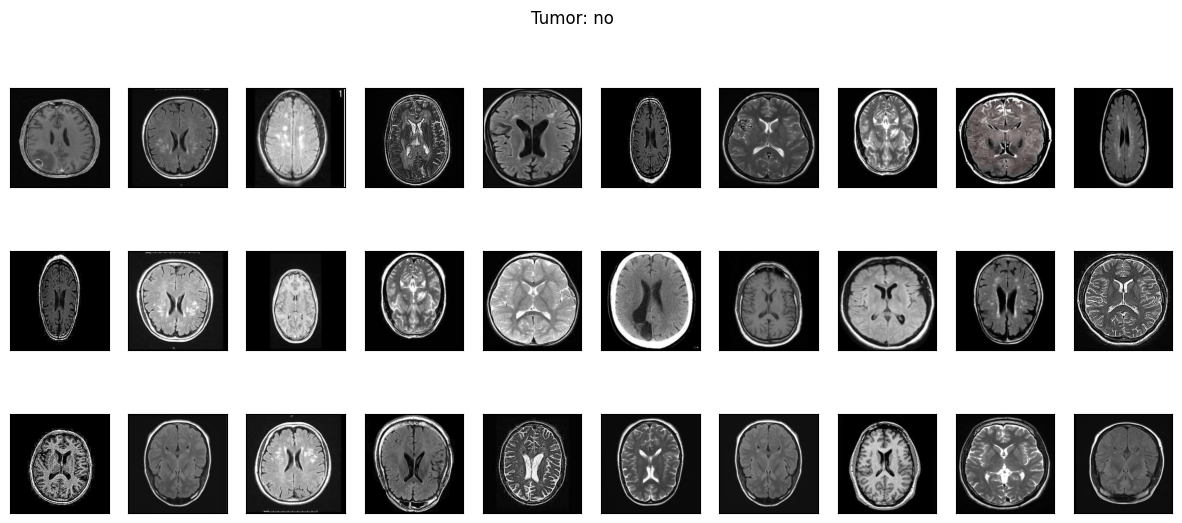

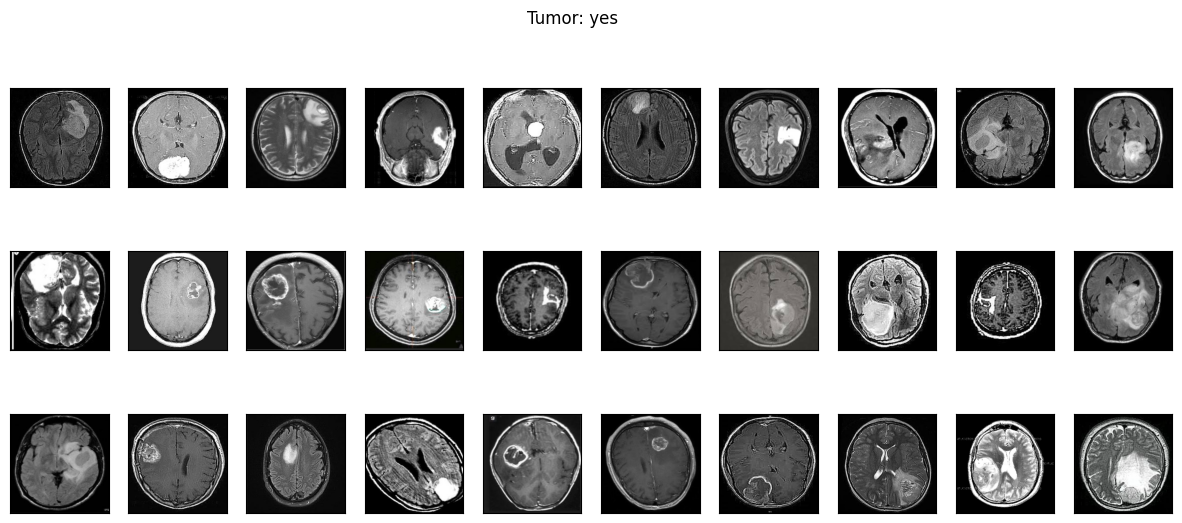

In [16]:
plot_samples(X_train, y_train, labels, 30)

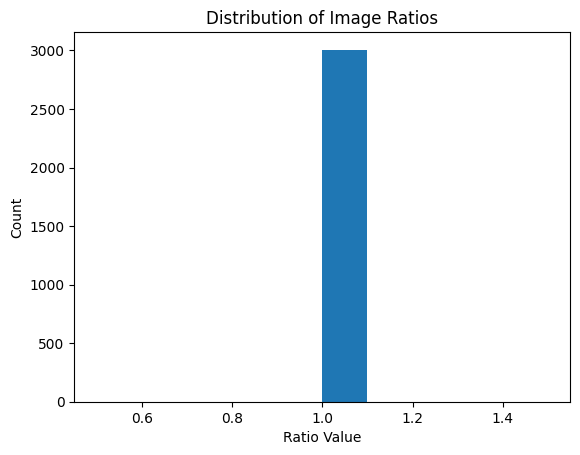

In [17]:
RATIO_LIST = []
for set in (X_train, X_test, X_val):
    for img in set:
        RATIO_LIST.append(img.shape[1]/img.shape[0])

plt.hist(RATIO_LIST)
plt.title('Distribution of Image Ratios')
plt.xlabel('Ratio Value')
plt.ylabel('Count')
plt.show()

DATA PREPROCESSING AND DATA ANALYSIS

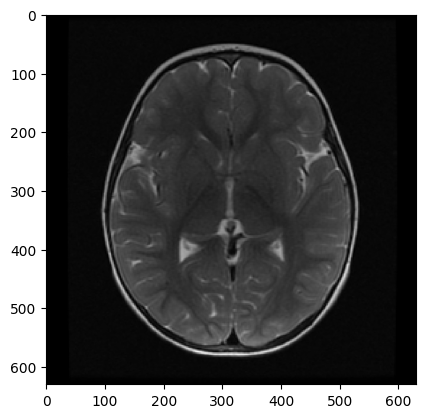

In [18]:
plt.imshow(plt.imread("/kaggle/input/brain-mri-scan-dataset/dataset/dataset/test/N1.jpeg"))

In [19]:
def crop_imgs(set_name, add_pixels_value=0):
    """
    Finds the extreme points on the image and crops the rectangular out of them
    """
    set_new = []
    for img in set_name:
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        gray = cv2.GaussianBlur(gray, (5, 5), 0)

        # threshold the image, then perform a series of erosions +
        # dilations to remove any small regions of noise
        thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
        thresh = cv2.erode(thresh, None, iterations=2)
        thresh = cv2.dilate(thresh, None, iterations=2)

        # find contours in thresholded image, then grab the largest one
        cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cnts = imutils.grab_contours(cnts)
        c = max(cnts, key=cv2.contourArea)

        # find the extreme points
        extLeft = tuple(c[c[:, :, 0].argmin()][0])
        extRight = tuple(c[c[:, :, 0].argmax()][0])
        extTop = tuple(c[c[:, :, 1].argmin()][0])
        extBot = tuple(c[c[:, :, 1].argmax()][0])

        ADD_PIXELS = add_pixels_value
        new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()

        # Resize the cropped image to a consistent size
        new_img = cv2.resize(new_img, (224, 224)) # Example size, adjust as needed

        set_new.append(new_img)

    return np.array(set_new)

In [20]:
!pip install imutils
import imutils

  Preparing metadata (setup.py) ... done
  Created wheel for imutils: filename=imutils-0.5.4-py3-none-any.whl size=25837 sha256=bb52a2e530a77eec615698e725b9e8a12202336ccc67119e379507addc39a05d
  Stored in directory: /root/.cache/pip/wheels/85/cf/3a/e265e975a1e7c7e54eb3692d6aa4e2e7d6a3945d29da46f2d7
Successfully built imutils


In [21]:
IMG_SIZE = (224,224)

img = cv2.imread('/kaggle/input/brain-mri-scan-dataset/dataset/dataset/test/N2.jpeg')
img = cv2.resize(
            img,
            dsize=IMG_SIZE,
            interpolation=cv2.INTER_CUBIC
        )
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
gray = cv2.GaussianBlur(gray, (5, 5), 0)

# threshold the image, then perform a series of erosions +
# dilations to remove any small regions of noise
thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
thresh = cv2.erode(thresh, None, iterations=2)
thresh = cv2.dilate(thresh, None, iterations=2)

# find contours in thresholded image, then grab the largest one
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
c = max(cnts, key=cv2.contourArea)

# find the extreme points
extLeft = tuple(c[c[:, :, 0].argmin()][0])
extRight = tuple(c[c[:, :, 0].argmax()][0])
extTop = tuple(c[c[:, :, 1].argmin()][0])
extBot = tuple(c[c[:, :, 1].argmax()][0])

# add contour on the image
img_cnt = cv2.drawContours(img.copy(), [c], -1, (0, 255, 255), 4)

# add extreme points
img_pnt = cv2.circle(img_cnt.copy(), extLeft, 8, (0, 0, 255), -1)
img_pnt = cv2.circle(img_pnt, extRight, 8, (0, 255, 0), -1)
img_pnt = cv2.circle(img_pnt, extTop, 8, (255, 0, 0), -1)
img_pnt = cv2.circle(img_pnt, extBot, 8, (255, 255, 0), -1)

# crop
ADD_PIXELS = 0
new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()

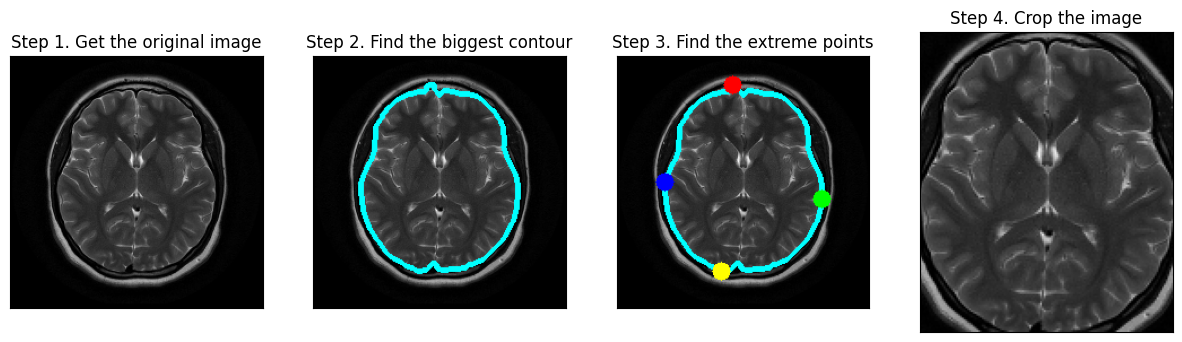

In [22]:
plt.figure(figsize=(15,6))
plt.subplot(141)
plt.imshow(img)
plt.xticks([])
plt.yticks([])
plt.title('Step 1. Get the original image')
plt.subplot(142)
plt.imshow(img_cnt)
plt.xticks([])
plt.yticks([])
plt.title('Step 2. Find the biggest contour')
plt.subplot(143)
plt.imshow(img_pnt)
plt.xticks([])
plt.yticks([])
plt.title('Step 3. Find the extreme points')
plt.subplot(144)
plt.imshow(new_img)
plt.xticks([])
plt.yticks([])
plt.title('Step 4. Crop the image')
plt.show()

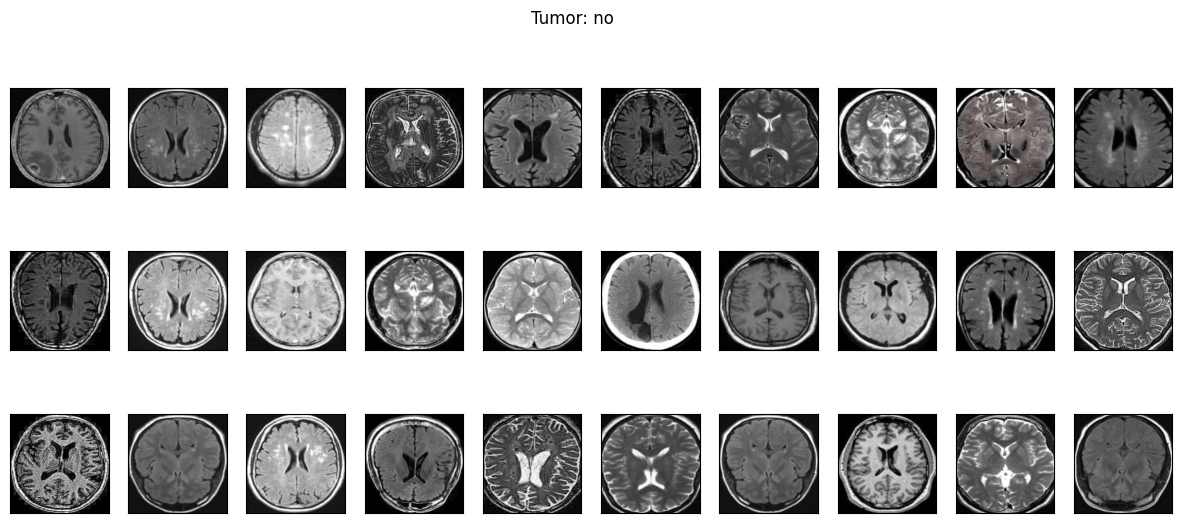

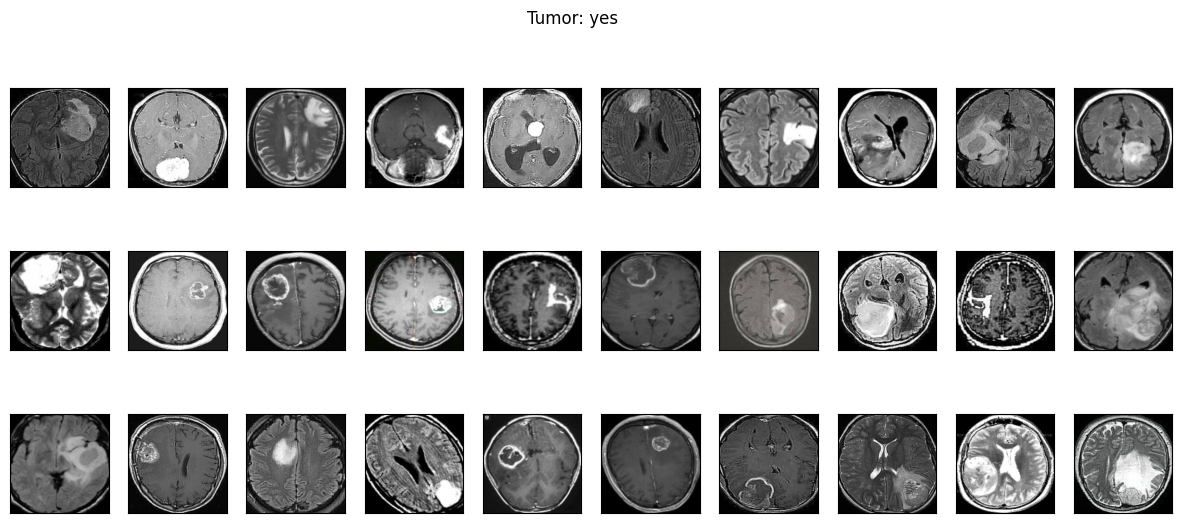

In [23]:
# apply this for each set
X_train_crop = crop_imgs(set_name=X_train)
X_val_crop = crop_imgs(set_name=X_val)
X_test_crop = crop_imgs(set_name=X_test)


plot_samples(X_train_crop, y_train, labels, 30)

In [24]:
def save_new_images(x_set, y_set, folder_name):
    i = 0
    for (img, imclass) in zip(x_set, y_set):
        if imclass == 0:
            cv2.imwrite(folder_name+'NO/'+str(i)+'.jpg', img)
        else:
            cv2.imwrite(folder_name+'YES/'+str(i)+'.jpg', img)
        i += 1

In [25]:
# saving new images to the folder
!mkdir TRAIN_CROP TEST_CROP VAL_CROP TRAIN_CROP/YES TRAIN_CROP/NO TEST_CROP/YES TEST_CROP/NO VAL_CROP/YES VAL_CROP/NO

save_new_images(X_train_crop, y_train, folder_name='TRAIN_CROP/')
save_new_images(X_val_crop, y_val, folder_name='VAL_CROP/')
save_new_images(X_test_crop, y_test, folder_name='TEST_CROP/')

In [26]:
# Resizing images to (224,224) and applying preprocessing.
def preprocess_imgs(set_name, img_size):
    """
    Resize and apply preprocessing
    """
    set_new = []
    for img in set_name:
        img = cv2.resize(
            img,
            dsize=img_size,
            interpolation=cv2.INTER_CUBIC
        )
        set_new.append(tf.keras.applications.imagenet_utils.preprocess_input(img)) # Added the correct function call
    return np.array(set_new)

In [27]:
X_train_prep = preprocess_imgs(set_name=X_train_crop, img_size=IMG_SIZE)
X_test_prep = preprocess_imgs(set_name=X_test_crop, img_size=IMG_SIZE)
X_val_prep = preprocess_imgs(set_name=X_val_crop, img_size=IMG_SIZE)

In [28]:
#Data Augementation

In [29]:
# set the paramters we want to change randomly
demo_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.05,
    height_shift_range=0.05,
    rescale=1./255,
    shear_range=0.05,
    brightness_range=[0.1, 1.5],
    horizontal_flip=True,
    vertical_flip=True
)

In [30]:
import os

# Check if the directory exists before trying to create it
if not os.path.exists('preview'):
    os.mkdir('preview')
x = X_train_crop[0]
x = x.reshape((1,) + x.shape)

i = 0
for batch in demo_datagen.flow(x, batch_size=1, save_to_dir='preview', save_prefix='aug_img', save_format='jpg'):
    i += 1
    if i > 20:
        break

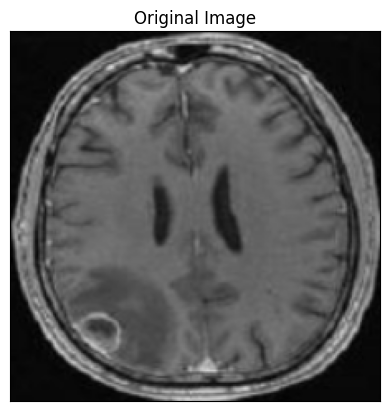

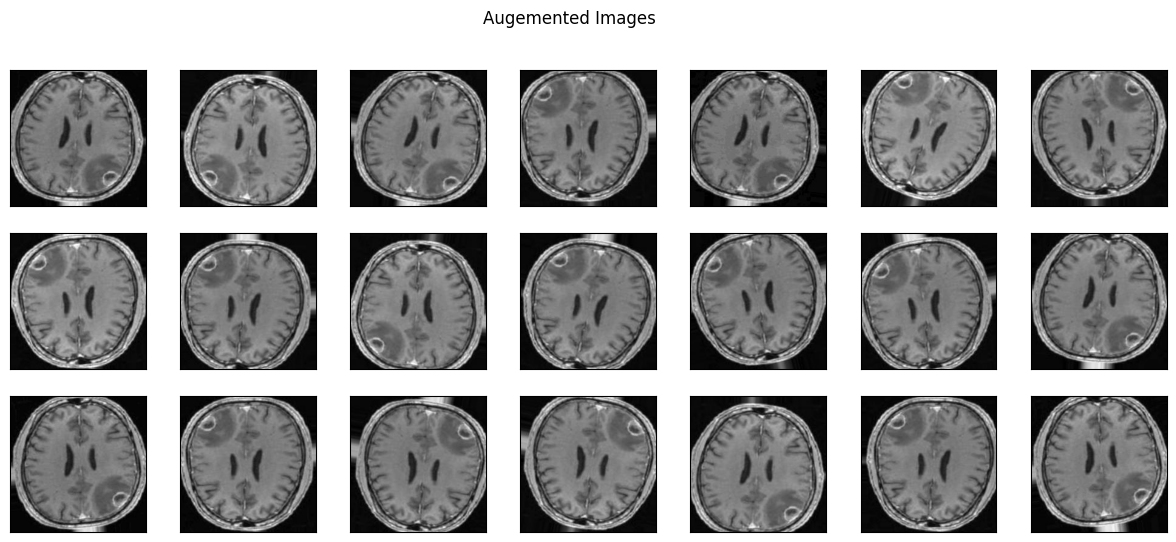

In [31]:
plt.imshow(X_train_crop[0])
plt.xticks([])
plt.yticks([])
plt.title('Original Image')
plt.show()

plt.figure(figsize=(15,6))
i = 1
for img in os.listdir('preview/'):
    img = cv2.imread('preview/' + img)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(3,7,i)
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    i += 1
    if i > 3*7:
        break
plt.suptitle('Augemented Images')
plt.show()

In [32]:
from tensorflow.keras.applications.imagenet_utils import preprocess_input

In [33]:
TRAIN_DIR = '/kaggle/working/TRAIN_CROP'
VAL_DIR = '/kaggle/working/VAL_CROP'
TEST_DIR = '/kaggle/working/TEST_CROP'
train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range = 0.1,
    brightness_range = [0.5,1.5],
    horizontal_flip = True,
    vertical_flip = True,
    preprocessing_function = preprocess_input
)
test_datagen = ImageDataGenerator(
    preprocessing_function = preprocess_input
)

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    color_mode='rgb',
    target_size=IMG_SIZE,
    batch_size=32,
    class_mode='binary',
    seed=RANDOM_SEED
)

validation_generator = test_datagen.flow_from_directory(
    VAL_DIR,
    color_mode='rgb',
    target_size=IMG_SIZE,
    batch_size=16,
    class_mode='binary',
    seed=RANDOM_SEED
)

Found 2800 images belonging to 2 classes.
Found 200 images belonging to 2 classes.


In [34]:
print(train_generator.class_indices)
print(validation_generator.class_indices)

{'NO': 0, 'YES': 1}
{'NO': 0, 'YES': 1}


In [35]:
!pip install imutils

In [36]:
from tensorflow.keras.applications.vgg16 import VGG16 # import the VGG16 class

In [37]:
vgg16_weight_path = ('/kaggle/input/keras-pretrained-models-for-computer-vision/Keras Pretrained Models/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5')
IMG_SIZE = (224,224)

base_model = VGG16(
    weights=vgg16_weight_path,
    include_top=False,
    input_shape= IMG_SIZE + (3,)
)

In [38]:
NUM_CLASSES = 1
base_model.trainable = False

input_shape = IMG_SIZE + (3,)
model = Sequential()
model.add(layers.InputLayer(shape=input_shape))
model.add(base_model)
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(NUM_CLASSES, activation='sigmoid'))


model.layers[0].trainable = False

model.compile(
    loss='binary_crossentropy',
    optimizer=Adam(learning_rate=1e-4),
    metrics=['accuracy']
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │        25,089 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,739,777 (56.23 MB)

 Trainable params: 25,089 (98.00 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [39]:
from tensorflow.keras.callbacks import EarlyStopping

In [49]:
EPOCHS = 30

es = EarlyStopping(
    monitor='accuracy',
    mode='max',
    patience=6)

history = model.fit(
    train_generator,
    steps_per_epoch=50,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=25,
    callbacks=[es]
)

Epoch 1/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 23s 403ms/step - accuracy: 0.9392 - loss: 0.4614 - val_accuracy: 0.9550 - val_loss: 0.4868
Epoch 2/30
 1/50 ━━━━━━━━━━━━━━━━━━━━ 5s 107ms/step - accuracy: 1.0000 - loss: 0.0057

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning:

Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.



50/50 ━━━━━━━━━━━━━━━━━━━━ 13s 266ms/step - accuracy: 0.9499 - loss: 0.3484 - val_accuracy: 0.9450 - val_loss: 0.6232
Epoch 3/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 23s 403ms/step - accuracy: 0.9448 - loss: 0.3999 - val_accuracy: 0.9650 - val_loss: 0.3769
Epoch 4/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 13s 257ms/step - accuracy: 0.9529 - loss: 0.3829 - val_accuracy: 0.9650 - val_loss: 0.4645
Epoch 5/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 23s 397ms/step - accuracy: 0.9541 - loss: 0.2764 - val_accuracy: 0.9650 - val_loss: 0.3810
Epoch 6/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 13s 261ms/step - accuracy: 0.9441 - loss: 0.3931 - val_accuracy: 0.9700 - val_loss: 0.3612
Epoch 7/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 23s 404ms/step - accuracy: 0.9596 - loss: 0.2797 - val_accuracy: 0.9650 - val_loss: 0.3625
Epoch 8/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 13s 259ms/step - accuracy: 0.9556 - loss: 0.2830 - val_accuracy: 0.9500 - val_loss: 0.5022
Epoch 9/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 23s 399ms/step - accuracy: 0.9496 - loss: 0.2887 - val_accuracy: 0.950

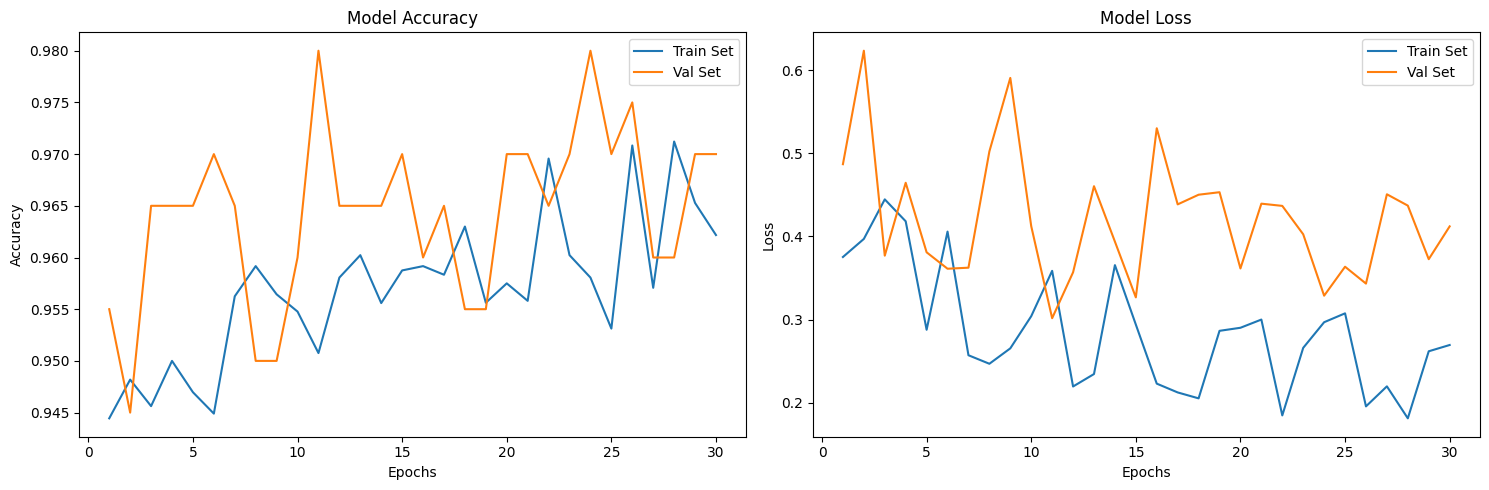

In [51]:
# plot model performance
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, len(history.epoch) + 1)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')

plt.tight_layout()
plt.show()

In [57]:
!pip install scikit-learn # install scikit-learn if it is not already installed.
from sklearn.metrics import accuracy_score # import the accuracy_score function from sklearn.metrics

In [58]:
!pip install matplotlib # make sure matplotlib is installed
import matplotlib.pyplot as plt # import matplotlib
import itertools

In [63]:
from sklearn.metrics import confusion_matrix

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step
Val Accuracy = 0.96


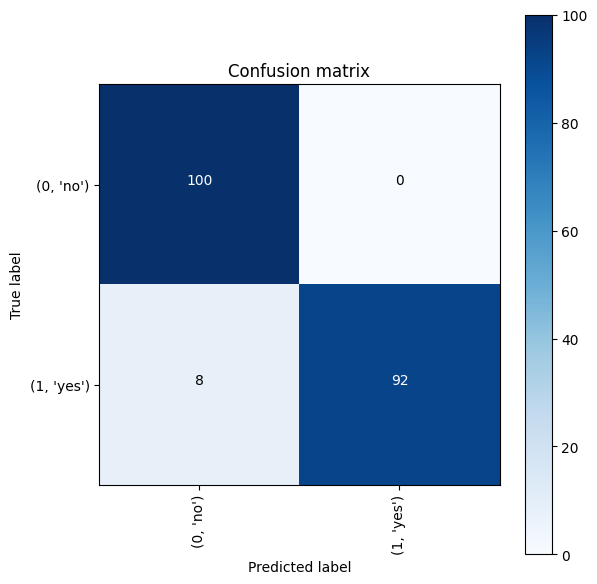

In [64]:
# validate on val set
predictions = model.predict(X_val_prep)
predictions = [1 if x>0.5 else 0 for x in predictions]

accuracy = accuracy_score(y_val, predictions)
print('Val Accuracy = %.2f' % accuracy)

confusion_mtx = confusion_matrix(y_val, predictions)
cm = plot_confusion_matrix(confusion_mtx, classes = list(labels.items()), normalize=False)

In [66]:
!pip install keras tensorflow
from tensorflow.keras.applications import ResNet50

In [67]:
resnet_weight_path = ('/kaggle/input/keras-pretrained-models-for-computer-vision/Keras Pretrained Models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5')
IMG_SIZE = (224,224)

base_model = ResNet50(
    # remove the weights argument
    # weights=resnet_weight_path,
    include_top=False,
    input_shape= IMG_SIZE + (3,)
)

# Load the weights with by_name=True and skip_mismatch=True
base_model.load_weights(resnet_weight_path, by_name=True, skip_mismatch=True)

#This code will load the weights from the file, but it will skip any layers where the shape don't match.
#This is used when using modified version of ResNet50 or if the weights file is not compatible with the Keras implementation of ResNet50.

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [69]:
NUM_CLASSES = 1
base_model.trainable = False

input_shape = IMG_SIZE + (3,)
model = Sequential()
model.add(layers.InputLayer(shape=input_shape))
model.add(base_model)
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(NUM_CLASSES, activation='sigmoid'))


model.layers[0].trainable = False

model.compile(
    loss='binary_crossentropy',
    optimizer=RMSprop(learning_rate=1e-4),
    metrics=['accuracy']
)
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │       100,353 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,688,065 (90.36 MB)

 Trainable params: 100,353 (392.00 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [70]:
EPOCHS = 30

es = EarlyStopping(
    monitor='accuracy',
    mode='max',
    patience=6)  

history = model.fit(
    train_generator,
    steps_per_epoch=50,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=25,
    callbacks=[es]
)

Epoch 1/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 42s 546ms/step - accuracy: 0.6439 - loss: 1.2564 - val_accuracy: 0.9100 - val_loss: 0.2606
Epoch 2/30
 2/50 ━━━━━━━━━━━━━━━━━━━━ 3s 78ms/step - accuracy: 0.8438 - loss: 0.7369

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning:

Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.



50/50 ━━━━━━━━━━━━━━━━━━━━ 14s 286ms/step - accuracy: 0.8477 - loss: 0.5198 - val_accuracy: 0.9050 - val_loss: 0.2760
Epoch 3/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 23s 395ms/step - accuracy: 0.8924 - loss: 0.3501 - val_accuracy: 0.9450 - val_loss: 0.2045
Epoch 4/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 12s 249ms/step - accuracy: 0.9066 - loss: 0.2857 - val_accuracy: 0.9050 - val_loss: 0.3824
Epoch 5/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 23s 396ms/step - accuracy: 0.9099 - loss: 0.2827 - val_accuracy: 0.8950 - val_loss: 0.4099
Epoch 6/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 13s 259ms/step - accuracy: 0.9213 - loss: 0.2342 - val_accuracy: 0.9100 - val_loss: 0.3921
Epoch 7/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 23s 395ms/step - accuracy: 0.9305 - loss: 0.2557 - val_accuracy: 0.9050 - val_loss: 0.3775
Epoch 8/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 13s 260ms/step - accuracy: 0.9308 - loss: 0.1971 - val_accuracy: 0.9600 - val_loss: 0.2301
Epoch 9/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 22s 394ms/step - accuracy: 0.9450 - loss: 0.1851 - val_accuracy: 0.970

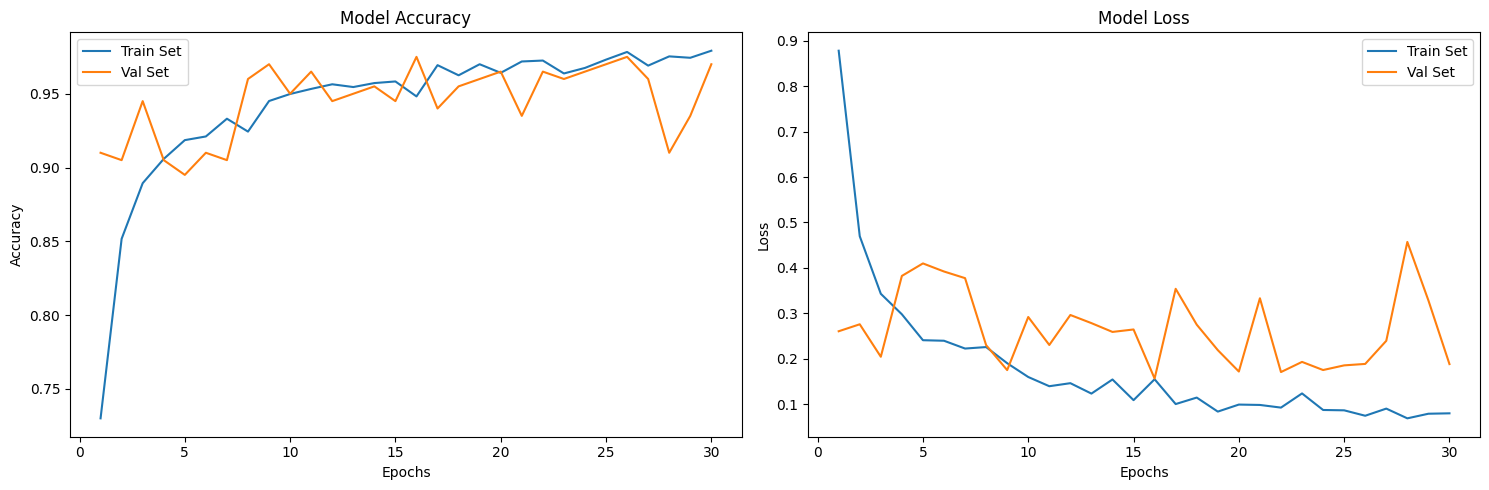

In [72]:
# plot model performance
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, len(history.epoch) + 1)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')

plt.tight_layout()
plt.show()

7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 699ms/step
Val Accuracy = 0.96


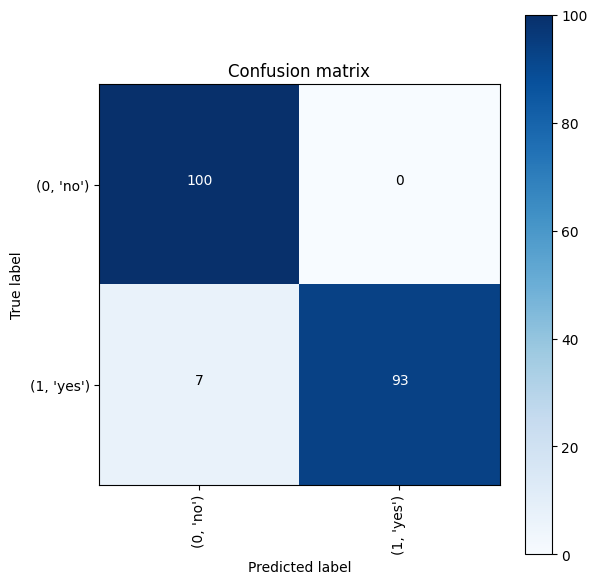

In [73]:
# validate on val set
predictions = model.predict(X_val_prep)
predictions = [1 if x>0.5 else 0 for x in predictions]

accuracy = accuracy_score(y_val, predictions)
print('Val Accuracy = %.2f' % accuracy)

confusion_mtx = confusion_matrix(y_val, predictions)
cm = plot_confusion_matrix(confusion_mtx, classes = list(labels.items()), normalize=False)

I have got 98% accuracy when trained with ResNet-50 and 96% accuracy when trained with VGG-16. Feel free to try diff architectures.

Thank you!!!